In [1]:
import numpy as np
import pandas as pd
import seaborn as sbs
from matplotlib.pyplot import plot as plt

In [2]:
pd.set_option('display.max_columns', 15)                                                    
pd.set_option('display.width', 300)                                                         
sbs.set(rc={'figure.figsize':(9, 6)})                                                       


Задача предсказать, закончит ли студент курс "Анализ данных в R", анализируя  его действия за первые N дней.

### 1. Подготовка данных

#### 1.1 Загружаем данные. Проверяем их структуру и типы

In [3]:
events_data = pd.read_csv('event_data_train.csv')
submission_data = pd.read_csv('submissions_data_train.csv')
events_data.head(5)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [4]:
events_data.dtypes


step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [5]:
events_data.action.unique()                                                                

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

Переводим Unix формата времени в стандартный date. Добавляем колонку date и day.
Смотрим минимальную и максимальную даты наблюдений.


In [6]:
events_data = events_data.assign(date = pd.to_datetime(events_data.timestamp, unit = 's'))
submission_data = submission_data.assign(date = pd.to_datetime(submission_data.timestamp, unit='s'))
events_data = events_data.assign(day = events_data.date.dt.date)
submission_data = submission_data.assign(day = submission_data.date.dt.date)

In [7]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [8]:
events_data.date.max()


Timestamp('2018-05-19 23:33:31')

Исходные данные соответствуют ожидаемым.

#### 1.2 Анализ данных

Для того, чтобы сформировать набор факторных переменных, от которых зависит успешность окончания курса студентом, и на которых будут обучаться модели, необходимо определить явные зависимости между входными данными. Также нужно определить, каких студентов можно считать покинувшими курс. 

Посчитаем количество уникальных студентов по дням и построим график зависимости.

In [9]:
events_data.groupby('day', as_index = False).agg({'user_id':'nunique'}).head(5)            

,day,user_id
0,2015-06-15,705
1,2015-06-16,526
2,2015-06-17,440
3,2015-06-18,411
4,2015-06-19,377


<Axes: xlabel='day'>

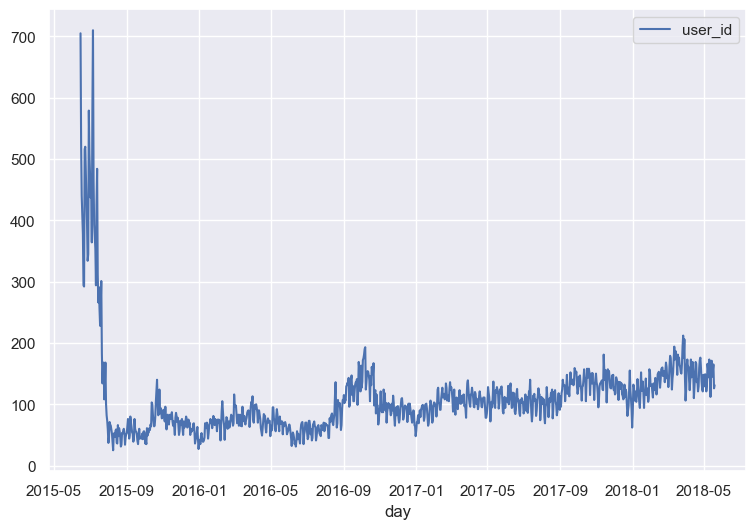

In [10]:
events_data.groupby('day').agg({'user_id':'nunique'}).reset_index().plot(x='day', y='user_id')

Согласно графику на старте курса число студентов, сделавших хотя бы одно действие, было почти в 3 раза выше, чем в последующие дни. Без учета стартового ажиотажа динамика числа уникальных студентов по дням положительная. 

Построим диаграмму распределения числа пользователей по количеству пройденных ими степов.

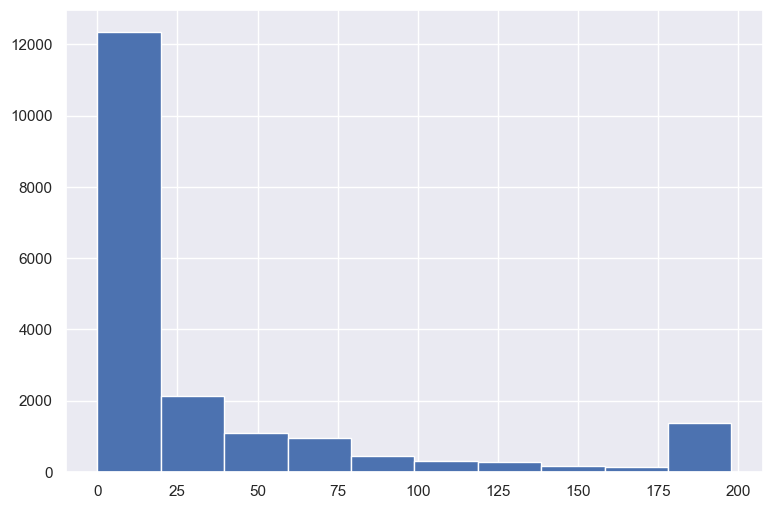

In [11]:
events_data_passed = events_data.pivot_table(index='user_id',                                                  
                        columns='action',                                                   
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).passed.hist()

Наибольшее снижение числа активных студентов происходит до 25 степа. Возможные причины: сложные задания на старте, начало курса не соответствует ожиданиям студентов. Будем считать студентов, прошедших 175 степов успешно завершившими курс.

Рассчитаем число правильных и неправильных ответов каждого студента. Это соотношение может влиять на желание студента продолжать курс.

In [12]:
users_scores = submission_data.pivot_table(index='user_id', 
                                           columns='submission_status',
                                           values='step_id',
                                           aggfunc='count', 
                                           fill_value=0).reset_index()
users_scores.head(5)

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


Чтобы вычислить студентов, которых можно считать покинувшими курс с некоторой вероятностью, возьмем среднее значение перерывов между какими-либо действиями студентов на курсе. Если перерывы в действиях студента превышают среднее значение, то считаем такого студента покинувшим курс.

In [13]:
# Проверка целостности данных (кол-во студентов совпадает в исходной и преобразованной таблицах.)
users_scores.user_id.nunique() == submission_data.user_id.nunique() 


True

In [14]:
events_data_passed = events_data.pivot_table(index='user_id', 
                                             columns='action',                              
                                             values='step_id',                             
                                             aggfunc='count', 
                                             fill_value=0).reset_index()

Вычисляем все разницы во времени между двумя ближайшими действиями каждого студента.
* удаляем повторные заходы пользователя на курс в течение дня
* группируем данные по user_id b и делаем списки со временем заходов на курс для каждого пользователя
* создаем списки с разницей между двумя соседними значениями (перерывы между действиями на курсе)
* объединяем в один массив данные из первых подмассивов gap_data и создаем серию
* переводим секунды в дни

In [15]:
gap_data = events_data[['user_id','day','timestamp']].drop_duplicates(subset=['user_id','day'])\
    .groupby('user_id')['timestamp'].apply(list)\
    .apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis = 0))
gap_data = gap_data/(24*60*60) 

Построим гистограмму перерывов между заходами на курс среди пользователей с лимитом до 100 дней.

<Axes: >

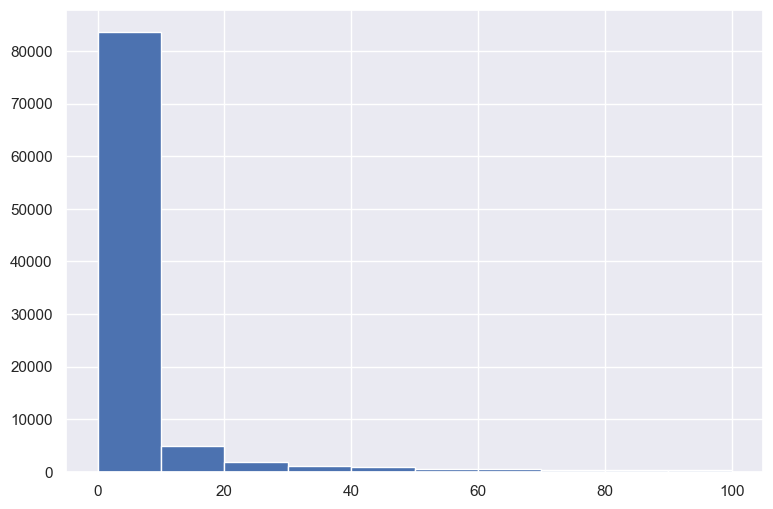

In [16]:
gap_data[gap_data < 100].hist()                                            

In [17]:
drop_out_time = gap_data.quantile(0.90)                                    
drop_out_time

18.325995370370403

Таким образом, перерывы между действиями на курсе у 90% пользователей не превышают 18 дней.

In [18]:
drop_out_time = gap_data.quantile(0.95)                                    
drop_out_time

59.760440972222156

Перерывы между действиями на курсе у 95 % пользователей не превышают 60 дней. Среднее значение между 90-ым и 95-ым квантилем - 30 дней. Это значение будем считать временем (drop_out), по истечение которого пользователь переводится в категорию покинувших курс. При условии, что у пользователя еще нет сертификата об окончании курса.

In [19]:
drop_out = 30*24*60*60

Последняя дата наблюдений: 

In [20]:
now = events_data.timestamp.max() 

Найдем время последнего действия на курсе для каждого пользователя.                            

In [21]:
user_data = events_data.groupby('user_id', as_index=False)\
.agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})  

Сравнивая разницу между последней датой наблюдений и временем последнего действия пользователя с установленным порогом в 30 дней, распределяем пользователей по категориям активных и покинувших курс.
                                                                             

In [22]:
user_data['is_gone'] = (now - user_data.last_timestamp) > drop_out
user_data.head(5)

,user_id,last_timestamp,is_gone
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


Создадим сводную таблицу, в которое отобразим id пользователей, время последнего посещения курса, количество правильных и неправильных ответов, количество различных действий и число дней, проведенных на курсе.

In [23]:
user_data = user_data.merge(users_scores, on='user_id', how='outer')
user_data = user_data.fillna(0)
user_data = user_data.merge(events_data_passed, how='outer')
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()
user_data = user_data.merge(user_days, on = 'user_id', how='outer')
user_data.head(5)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


Проверяем целостность данных: кол-во user_id в user_data должно совпадать с исходными данными.

In [24]:
user_data.user_id.nunique() == events_data.user_id.nunique()                                                  

True

Ранее мы определили, что студенты, прошедшие более 175 степов будут считаться успешно окончившими курс. Добавим новую колонку в user_data, где будем проверять это условие.

In [25]:
user_data['passed_course'] = user_data.passed > 175
user_data.head(5)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


Для проверки адекватности преобразованных данных вычислим соотношение числа студентов прошедших и покинувших курс.

In [26]:
user_data.groupby('passed_course').count().reset_index()                      

,passed_course,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day
0,False,17844,17844,17844,17844,17844,17844,17844,17844,17844,17844
1,True,1390,1390,1390,1390,1390,1390,1390,1390,1390,1390


In [27]:
100 * 1390 / 17844

7.789733243667339

Приблизительно 8% студентов успешно заканчивают курс. Значение находится на уровне средних значений в индустрии онлайн-обучения.

#### 1.3 Формулировка гипотезы

Вычислим медиану количества учебных дней студентов, успешно закончивших курс.

In [28]:
day_median = user_data[user_data.passed_course == True].day.median()
day_median

21.0

Половина закончивших курс студентов занималась менее 21 дня. Выясним, можно ли по поведению пользователя за первые 3 дня (learning_day) предсказать, закончит ли он курс.

In [29]:
learning_day = 3*24*60*60   

Вычислим время начала курса для каждого пользователя и добавим это время в таблицу user_data. В другую колонку добавляем в время равное 3 дням обучения с начала курса min_timestamp + learning_day.


In [30]:
user_min_time = events_data.groupby('user_id', as_index=False)\
    .agg({'timestamp':'min'}).rename({'timestamp':'min_timestamp'}, axis=1)
user_data = user_data.merge(user_min_time, how='outer')
user_data['min_time + 3days'] = user_data.min_timestamp + learning_day 
user_data.head(5)

,user_id,last_timestamp,is_gone,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp,min_time + 3days
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464,1473086664
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364,1514642564
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476,1434617676
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809,1466416009
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660,1521893860


Выберем действия каждого студента в первые три дня его занятий из таблицы events_data.

In [31]:
user_data_temp = user_data[['user_id','min_time + 3days']]    
events_data_temp = events_data.merge(user_data_temp, on = 'user_id', how = 'outer')
events_data_train = events_data_temp[events_data_temp['timestamp'] <= events_data_temp['min_time + 3days']]
events_data_train.head(5)

,step_id,timestamp,action,user_id,date,day,min_time + 3days
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,1434600048


Проверим, что в полученной таблице максимальное число дней, которое занимались студенты , не более 4.

In [32]:
events_data_train.groupby('user_id').agg({'day':'nunique'}).max()                          

day    4
dtype: int64

Выберем данные студента в первые три дня его занятий из таблицы submission_data.


In [33]:
submission_data_temp = submission_data.merge(user_data_temp, on = 'user_id', how = 'outer')
submission_data_train = submission_data_temp[submission_data_temp['timestamp'] <= submission_data_temp['min_time + 3days']]
submission_data_train.head(5)

,step_id,timestamp,submission_status,user_id,date,day,min_time + 3days
0,31971.0,1.434349e+09,correct,15853,2015-06-15 06:21:15,2015-06-15,1434605177
1,31972.0,1.434348e+09,correct,15853,2015-06-15 06:05:00,2015-06-15,1434605177
4,31976.0,1.434348e+09,wrong,15853,2015-06-15 06:02:03,2015-06-15,1434605177
5,31976.0,1.434348e+09,correct,15853,2015-06-15 06:03:08,2015-06-15,1434605177
7,31977.0,1.434347e+09,correct,15853,2015-06-15 05:49:31,2015-06-15,1434605177


In [34]:
submission_data_train.groupby('user_id').agg({'day':'nunique'}).max()

day    4
dtype: int64

### 2. Формируем данные для обучения моделей

Полученные таблицы submission_data_train и events_data_train позволяют сформировать факторные переменные X и целевую переменную y, на основе которых будем обучать модели.







In [35]:
# Число уникальных дней пользователя на курсе
X = submission_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

# Кол-во уникальных степов, которые проходил пользователь
steps_tried = submission_data_train.groupby('user_id').step_id.nunique()\
    .to_frame().reset_index().rename(columns={'step_id':'steps_tried'})
X = X.merge(steps_tried, on='user_id', how='outer')

# Числом правильных и неправильных ответов пользователя
X = X.merge(submission_data_train.pivot_table(index='user_id',                               
                                                 columns='submission_status',
                                                 values='step_id',
                                                 aggfunc='count', fill_value=0).reset_index())

# Доля верных ответов
X['correct_ratio'] = (X.correct/(X.correct + X.wrong)).round(2)

# Число различных действий пользователя
X = X.merge(events_data_train.pivot_table(index='user_id',                               
                                                 columns='action',
                                                 values='step_id',
                                                 aggfunc='count', fill_value=0).reset_index()[['user_id','viewed']], how ='outer')

X = X.fillna(0)

# Добавляем колонки из user_data
X = X.merge(user_data[['user_id','passed_course', 'is_gone']], on='user_id', how='outer')

Отбираем пользователей, которые прошли курс, либо которые ещё его проходят (не бросили).                                                                       

In [36]:
X = X.query('passed_course==True or is_gone==True')

Выбираем целевую переменную y и удаляем эту колонку из X.

In [37]:
y = X.passed_course.map(int)
X = X.drop(['passed_course', 'is_gone'], axis=1)  

Так как user_id не является факторной переменной, то делаем из этой колонки индексы.

In [38]:
X = X.set_index(X.user_id)
X = X.drop(['user_id'], axis=1)

In [39]:
X.head(5)

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


Таким образом, получили таблицу с факторными переменными X, которые отражают поведение пользователя в первые три дня обучения на курсе. И таблицу с целевой переменной y, которая показывает, закончил ли студент курс или нет. 

###  3. Обучение моделей и прогнозирование

In [40]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn import metrics
from sklearn import tree

#### 3.1 Дерево решений

Разобьем тренировочный датасэт на значения для тренировки и тестирования модели в соотношении 20/80.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=41)           

In [42]:
# Создадим заготовку модели дерева решений без параметров
clf = tree.DecisionTreeClassifier()

# Создаим словарь параметров дерева и диапазон их значений
parameters = {'criterion':['gini', 'entropy'], 'max_depth': range(3,6), 'max_leaf_nodes':range(6,15), 'min_samples_leaf': range(1,4),'min_samples_split':range(2,5)}

# Заготовка поискового алгоритма
grid_search_cv_clf = GridSearchCV(clf, parameters, cv=4)


# Ищем лучшую модель на тренировочных данных
grid_search_cv_clf.fit(X_train, y_train)

# Модель дерева с лучшими параметрами
model_tree = grid_search_cv_clf.best_estimator_ 

# Смотрим параметры оптимального дерева
grid_search_cv_clf.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

Рассчитаем среднюю точность валидации на тренировочных и тестовых данных.

In [43]:
cross_val_score(model_tree, X_train, y_train, cv=4).mean()                         

0.9256813125695217

In [44]:
model_tree.score(X_test, y_test)                                                

0.9179644048943271

Построенная модель дерева решений model_tree верно классифицировала 93% объектов из тренировочных данных и 92% объектов из тестовых данных.
Сделаем прогноз по тестовым данным и оценим его качество.

In [45]:
y_pred = model_tree.predict(X_test)

In [46]:
precision_score(y_test, y_pred)                             

0.6

Точность (true positives / (true positives + false positives)) модели равна 0.6. Таким образом, из всех объектов, которые модель отнесла к классу 'закончивших курс', только 60% действительно принадлежат к этому классу.

In [47]:
recall_score(y_test, y_pred)                                

0.04013377926421405

Полнота (true positives / (true positives + false negatives)) модели равна 0.04. Таким образом, модель обнаруживает только 4% объектов класса 1.

In [48]:
f1_score(y_test, y_pred)

0.07523510971786834

Cреднее гармоническое между precision и recall, равно 0.075. Модель имеет низкое качество на данной задаче.

Создадим итоговый фрейм с факторными переменными и вычисленными прогнозными значениями.

In [49]:
predictions_tree = pd.DataFrame(data = y_pred, columns = ['prediction'])
X_test_tree = X_test.assign(prediction = y_pred)

#### 3.2 Логистическая регрессия

In [50]:
from sklearn.linear_model import LogisticRegressionCV

In [51]:
clf1 = LogisticRegressionCV(cv=5)

In [52]:
clf1.fit(X_train, y_train)

LogisticRegressionCV(cv=5)

In [53]:
clf1.score(X_test, y_test)

0.9187986651835373

In [54]:
cross_val_score(clf1, X_train, y_train, cv=4).mean()

0.925194660734149

In [55]:
y_pred1 = clf1.predict(X_test)

In [56]:
precision_score(y_test, y_pred1)

0.5466666666666666

In [57]:
recall_score(y_test, y_pred1)

0.13712374581939799

In [58]:
f1_score(y_test, y_pred1)

0.2192513368983957

#### 3.3 Алгоритм ближайшего соседа

In [59]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
knn = KNeighborsClassifier()

In [61]:
parameters = {'n_neighbors': range(15, 25), 'leaf_size': range(1, 7)}

In [62]:
grid_search_cv_knn = GridSearchCV(knn, parameters, cv=4, n_jobs=-1)

In [ ]:
grid_search_cv_knn.fit(X_train, y_train)

In [ ]:
model_knn = grid_search_cv_knn.best_estimator_

In [ ]:
cross_val_score(model_knn, X_train, y_train, cv=4).mean()

In [ ]:
y_pred2 = model_knn.predict(X_test)

In [ ]:
precision_score(y_test, y_pred2)

In [ ]:
recall_score(y_test, y_pred2)

In [ ]:
f1_score(y_test, y_pred2)

Таким образом, наилучшее качество имеет модель логистической регрессии с метрикой f1 = 0.22. Высокая точность всех моделей при крайне низкой полноте может быть связано с несбалансированностью классов в выборке. Проведем тюнинг прогнозов по этой модели и вычислим новые метрики.

#### 3.4 Тюнинг прогнозных значений по модели логистической регрессии


Получим массив с вероятностями отнесения наблюдения к классу 0 (False passed course). Перепишем прогнозные значения по модели логистической регрессии, принудительно назначая класс 0 наблюдению, если вероятность его отнесения к этому классу моделью больше заданного значения.

In [ ]:
y_prob_log = clf1.predict_proba(X_test)  
y_new_log = np.where(y_prob_log[:,0] > 0.85, 0, 1) 

In [ ]:
precision_score(y_test, y_new_log)

In [ ]:
recall_score(y_test, y_new_log)

In [ ]:
f1_score(y_test, y_new_log)

Определим вклад каждого фактора в прогноз.

In [ ]:
model_tree.feature_importances_
model_tree_feature_importances = pd.DataFrame({'feature': X.columns, 'impotance': model_tree.feature_importances_ })
model_tree_feature_importances.plot(kind='barh', x ='feature')

В заключении можно сказать, что по данным о поведении студента в течение первых трех дней модель логистической регрессии может предсказать закончит ли студент курс с точностью 42%. Наибольшее значение для целевого показателя имеет фактор количества правильных ответов студента. 